# **Optimizing Solar Tracking using AI**

The main purpose of this project is to fundamentally design a solar tracking system to improve the efficiency of the solar panel systems that may have solar tracking capabilities. This study demonstrates how we can fundamentally improve the accuracy of our solar tracking capabiities while observing the charactersistics of different AI NN types.

Observed AI NN Types:
- Artificial Neural Network (ANN)
- Kolmogorov-Arnold Networks (KAN)

Possible AI NN Types:
- Recurrent Neural Networks (RNN)
- Generative Averserial Networks (GAN)
- Radial Basis Function (RBF)
- Boltzaman Machine (BM)
- Modular Neural Network (Mod-NN)

In [252]:
# Libraries for data science & analytics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import pandas as pd
import matplotlib.pyplot as plt

# Libraries for solar stuff
from pysolar.solar import *
import datetime
import numpy as np

#%matplotlib inline

## Solar Tracking Data

The solar tracking dataset was created using two different sources of information. One of them was a trimmed version of the 8.7GB file that provides Solar to Grid public data based on an hourly rate of production for the population in Arizona [[Lawrence Berkeley National Lab. (2021). Solar-to-Grid Public Data File](https://doi.org/10.25984/1825661)].

In [253]:
def convertStrToDateTime(date_time:str)->datetime.datetime:
    if isinstance(date_time, (int, float)):
        return datetime.datetime.fromtimestamp(date_time, tz=datetime.timezone.utc)
    elif isinstance(date_time, str) and date_time.replace('.', '', 1).isdigit():
        return datetime.datetime.fromtimestamp(float(date_time), tz=datetime.timezone.utc)
    
    try:
        return datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S%z')
    except ValueError:
        return datetime.datetime.strptime(date_time, '%Y-%m-%d %H:%M:%S')

### Data Processing

The data processing necessary for us to operate within our own parameters is important since we are mostly focused on a specific year & season [May, September] 2019.

#### Required functions for ease of data processing

In [254]:
# selects only a section of the data that is vital for our needs
def trimDataByTimeFrame(data:pd.DataFrame, start_date_and_time:str, end_date_and_time:str):
  return data[data.index[data['Date_and_Time'] == start_date_and_time].tolist()[0]:
              data.index[data['Date_and_Time'] == end_date_and_time].tolist()[0]]

# easily plots 2 variables and creates a graph
def plotData(x, y, x_label:str, y_label:str, title:str):
  plt.plot(x, y)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

#### Solar Data - Data Pruning & Analysis
Data Is from Gilmer Counter Georgia


In [255]:
import pandas as pd

# Read csv file & properly assign the dataframe with column names
df = pd.read_csv("hourly generation by plant and county/DPV by county/13123.csv")
df.columns = ['Date_and_Time', 'DPV_res_MW', 'DPV_non_res_MW', 'CF', 'DPV_res_MWh', 'DPV_non_res_MWh']

# desired time frame
sdat = "2019-05-01 00:00:00+00:00"
edat = "2019-10-01 00:00:00+00:00"

# trim the data
timed_data = trimDataByTimeFrame(df, start_date_and_time=sdat, end_date_and_time=edat)
timed_data.to_csv("trimed_data.csv", index=False)

# prune the data so that we don't have to deal with this later
pruned_data = timed_data.copy()

# combine like terms
pruned_data.loc[:,"DPV_Combined_MW"] = pruned_data['DPV_res_MW'] + pruned_data['DPV_non_res_MW']
pruned_data.loc[:,"DPV_Combined_MWh"] = pruned_data['DPV_res_MWh'] + pruned_data['DPV_non_res_MWh']

# drop data
for i in ['DPV_res_MW', 'DPV_non_res_MW', 'CF', 'DPV_res_MWh', 'DPV_non_res_MWh']:
  pruned_data.pop(i)

# save data to csv and print out the finally pruned data
pruned_data.to_csv("pruned_data.csv", index=False)
print("Pruned Data")
print(pruned_data)

# For the solar angle relative to position calculations
pruned_data["Date_and_Time"].to_csv("date_times.csv", index=False)
input_data = pruned_data.copy()



Pruned Data
                   Date_and_Time  DPV_Combined_MW  DPV_Combined_MWh
81763  2019-05-01 00:00:00+00:00         0.052691          0.000000
81764  2019-05-01 01:00:00+00:00         0.052692          0.000000
81765  2019-05-01 02:00:00+00:00         0.052693          0.000000
81766  2019-05-01 03:00:00+00:00         0.052694          0.000000
81767  2019-05-01 04:00:00+00:00         0.052695          0.000000
...                          ...              ...               ...
85430  2019-09-30 19:00:00+00:00         0.056386          0.037186
85431  2019-09-30 20:00:00+00:00         0.056386          0.030708
85432  2019-09-30 21:00:00+00:00         0.056387          0.021099
85433  2019-09-30 22:00:00+00:00         0.056388          0.008937
85434  2019-09-30 23:00:00+00:00         0.056389          0.000000

[3672 rows x 3 columns]


#### Output Data - Data Pruning & Analysis

In [256]:
from datetime import timezone
from pysolar.solar import get_altitude, get_azimuth

latitude = 34.766402181439396
longitude = -84.5666744211403

def calculate_solar_angles(timestamps, lat,long):
    altitudes = []
    azimuths = []

    for t in timestamps:
        dt = convertStrToDateTime(t).replace(tzinfo=timezone.utc)
        altitudes.append(get_altitude(lat, long, dt))
        azimuths.append(get_azimuth(lat, long, dt))

    return altitudes, azimuths    

altitudes, azimuths = calculate_solar_angles(pruned_data["Date_and_Time"], latitude, longitude)
pruned_data["Solar_Altitude"] = altitudes
pruned_data["Solar_Azimuth"] = azimuths

#convert azimuth to rad
azimuth_rad = np.deg2rad(pruned_data['Solar_Azimuth'])

# Create new columns for sin and cos of azimuth
pruned_data['azimuth_sin'] = np.sin(azimuth_rad)
pruned_data['azimuth_cos'] = np.cos(azimuth_rad)

pruned_data[["Date_and_Time", "Solar_Altitude", "Solar_Azimuth", "azimuth_sin", "azimuth_cos"]].to_csv("solar_angles_with_sincos_2019.csv", index=False)

#Print head to preview data
print(pruned_data[['Solar_Altitude', 'azimuth_sin', 'azimuth_cos']].head())

       Solar_Altitude  azimuth_sin  azimuth_cos
81763        3.746693    -0.962570     0.271033
81764       -8.014508    -0.910041     0.414517
81765      -18.731167    -0.823799     0.566882
81766      -28.092801    -0.686960     0.726696
81767      -35.347316    -0.478882     0.877879


## Artificial Neural Network (ANN)

The purpose of the ANN is to show the capabilities of a functional AI based on the traditional methods of using AI to solve problems. The solar tracking is done by passing [x,y,z] to the input and the output is [Θ].

PLEASE ADD A DIAGRAM HERE OF YOUR NN...


### ANN Class

In [257]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

#ANN Class
class SolarTrackingNN(nn.Module):
  def __init__(self):
    super(SolarTrackingNN, self).__init__()
    self.fc1 = nn.Linear(3,32) # First hidden layer: 3 inputs → 20 neurons
    self.fc2 = nn.Linear(32,32) # Second hidden layer: 20 → 20 neurons
    self.fc3 = nn.Linear(32,3) # Output layer: 20 → 2 outputs

    #Foward pass
  def forward(self, x):
    x = torch.relu(self.fc1(x)) # ReLU activation
    x = torch.relu(self.fc2(x)) # ReLU activation
    x = self.fc3(x)             # Linear output
    return x

#Created model
AI_model = SolarTrackingNN()
#Loss function
loss_funct = nn.MSELoss()
#Optimizer
Optimizer = optim.Adam(AI_model.parameters(), lr=0.00005)






#Data Preparation
# X = Features y = targets as pd dataframes

#Input Features X
X_df = input_data.copy()
X_df["Date_and_Time"] = (pd.to_datetime(X_df["Date_and_Time"]).astype('int64') // 10**9)

#Target Variables Y
y_df = pruned_data[['Solar_Altitude', 'azimuth_sin', 'azimuth_cos']].copy()

print(X_df.head())

# Splitting into training, validation, and test sets

# Splits training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_df, y_df, test_size=0.15, random_state=42 # 15% for test set
)

# Then split training+validation into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=42 # Approx 15% of original for val
)



#Input features and scalars
scaler = StandardScaler()

#Fitting scalar to only input features
X_train_scaled = scaler.fit_transform(X_train)
#Applying the same scalar to validation and test features
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



#Converting all scalers to pytorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


#Creating respective datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)



#Set standard batch size
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False) # Set val and test to false for consistent performance
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Printing for testing purposes
print(f"Training samples: {len(X_train_tensor)}")
print(f"Validation samples: {len(X_val_tensor)}")
print(f"Test samples: {len(X_test_tensor)}")



       Date_and_Time  DPV_Combined_MW  DPV_Combined_MWh
81763     1556668800         0.052691               0.0
81764     1556672400         0.052692               0.0
81765     1556676000         0.052693               0.0
81766     1556679600         0.052694               0.0
81767     1556683200         0.052695               0.0
Training samples: 2570
Validation samples: 551
Test samples: 551


### ANN Training

[Guide for training ANN](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html://)


[link text](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html://)


Epoch 1 Training completed. Average training Loss: 16091.090134
Epoch 1 Validation Completed. Average Val Loss: 15631.994249
 Average Val MAE: 11.5645
Epoch 2 Training completed. Average training Loss: 16060.706667
Epoch 2 Validation Completed. Average Val Loss: 15602.476585
 Average Val MAE: 11.5538
Epoch 3 Training completed. Average training Loss: 16029.318931
Epoch 3 Validation Completed. Average Val Loss: 15570.494175
 Average Val MAE: 11.5419
Epoch 4 Training completed. Average training Loss: 15995.757013
Epoch 4 Validation Completed. Average Val Loss: 15537.581160
 Average Val MAE: 11.5292
Epoch 5 Training completed. Average training Loss: 15960.361061
Epoch 5 Validation Completed. Average Val Loss: 15501.602020
 Average Val MAE: 11.5149
Epoch 6 Training completed. Average training Loss: 15921.727819
Epoch 6 Validation Completed. Average Val Loss: 15462.167808
 Average Val MAE: 11.4983
Epoch 7 Training completed. Average training Loss: 15878.916013
Epoch 7 Validation Completed. 

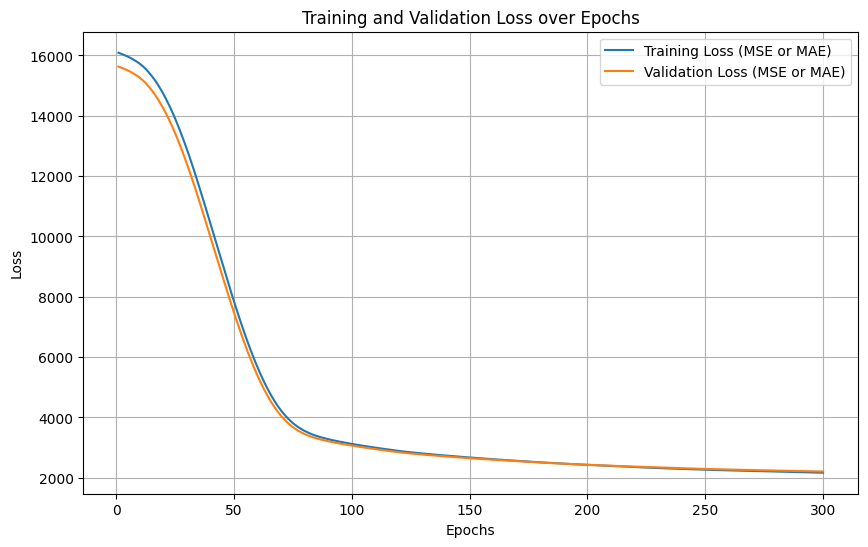

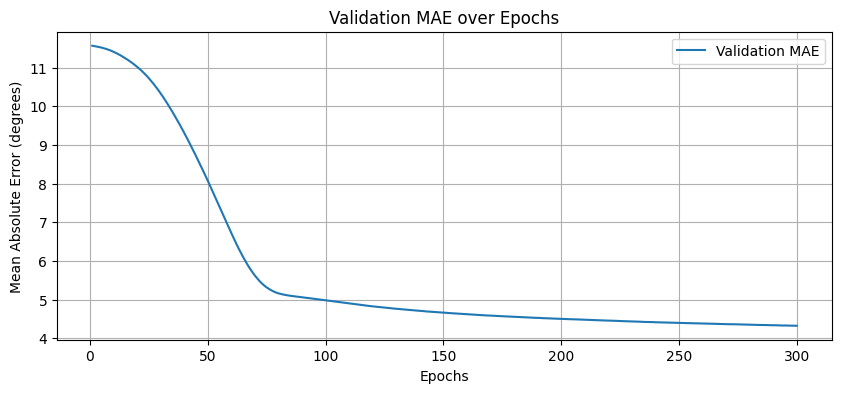

In [258]:


def train(model, train_loader, val_loader, loss_function, optimizer, epochs=10):
    model.train()  # Set model to training mode
    training_loss_history = []
    val_loss_history = []
    val_mae_history = []
    
    for epoch in range(epochs):


        #Training Phase
        model.train()
        running_train_loss = 0.0
        batch_training_losses = []
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Zero the gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Track loss
            running_train_loss += loss.item() * inputs.size(0)
            batch_training_losses.append(loss.item())
            
            # Print batch statistics
            if batch_idx % 100 == 99:  # Print every 100 batches
                avg_batch_loss = sum(batch_training_losses[-100:])/100
                print(f'Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {avg_batch_loss:.6f}')
        
        # Calculate average epoch loss
        epoch_training_loss = running_train_loss / len(train_loader)
        training_loss_history.append(epoch_training_loss)
        print(f'Epoch {epoch+1} Training completed. Average training Loss: {epoch_training_loss:.6f}')



        #Validation Phase
        model.eval()
        running_val_loss = 0.0
        running_val_mae = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                running_val_loss += loss.item() * inputs.size(0)

                mae = torch.nn.functional.l1_loss(outputs, targets, reduction='sum')
                running_val_mae += mae.item()
        

        epoch_val_mae = running_val_mae / (len(val_loader.dataset) * targets.size(1)) # per angle
        epoch_val_loss = running_val_loss / len(val_loader)
        val_loss_history.append(epoch_val_loss)
        val_mae_history.append(epoch_val_mae)
        print(f'Epoch {epoch+1} Validation Completed. Average Val Loss: {epoch_val_loss:.6f}')
        print(f' Average Val MAE: {epoch_val_mae:.4f}')

    model.eval()
    print("\n--- Sample Predictions from Validation Set (End of Training) ---")
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(val_loader):
            if i >= 1: # Look at first 5 batches for example
                break
            outputs = model(inputs)
            for j in range(min(inputs.size(0), 5)): # Show up to 5 samples from this batch
                scaled_input_features = inputs[j].cpu().numpy()
                
                # Predicted values
                pred_alt = outputs[j][0].item()
                pred_az_sin = outputs[j][1].item()
                pred_az_cos = outputs[j][2].item()
                # Convert predicted sin/cos back to azimuth degrees
                pred_az_deg = np.rad2deg(np.arctan2(pred_az_sin, pred_az_cos))
                pred_az_deg = (pred_az_deg + 360) % 360 # Normalize to 0-360

                # Actual values
                actual_alt = targets[j][0].item()
                actual_az_sin = targets[j][1].item()
                actual_az_cos = targets[j][2].item()
                # Convert actual sin/cos back to azimuth degrees (for comparison)
                actual_az_deg = np.rad2deg(np.arctan2(actual_az_sin, actual_az_cos))
                actual_az_deg = (actual_az_deg + 360) % 360 # Normalize to 0-360

                print(f"Sample {j+1}:")
                print(f"  Input (scaled): {scaled_input_features}")
                print(f"  Predicted: Alt={pred_alt:.2f}, Az_sin={pred_az_sin:.2f}, Az_cos={pred_az_cos:.2f} => Az_deg={pred_az_deg:.2f}")
                print(f"  Actual:    Alt={actual_alt:.2f}, Az_sin={actual_az_sin:.2f}, Az_cos={actual_az_cos:.2f} => Az_deg={actual_az_deg:.2f}")
                
                # Calculate angular error for azimuth
                az_error = pred_az_deg - actual_az_deg
                az_error = (az_error + 180) % 360 - 180 # Normalize error to -180 to 180

                print(f"  Error:     Alt_Err={(pred_alt - actual_alt):.2f}, Az_Err(deg)={az_error:.2f}")
                print("-" * 20)

    return training_loss_history, val_loss_history, val_mae_history

# Train the model
train_loss_hist, val_loss_hist , val_mae_history = train(AI_model, train_loader, val_loader, loss_funct, Optimizer, epochs=300)


# Plotting loss over epochs
def plot_loss_curves(train_loss_history, val_loss_history): # Takes actual loss history lists
  num_epochs = len(train_loss_history)
  plt.figure(figsize=(10, 6))
  plt.plot(range(1, num_epochs + 1), train_loss_history, label='Training Loss (MSE or MAE)')
  plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss (MSE or MAE)')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss over Epochs')
  plt.legend()
  plt.grid(True)
  # To save the figure:
  # plt.savefig('loss_curves.png')
  plt.show()

plot_loss_curves(train_loss_hist, val_loss_hist)

plt.figure(figsize=(10, 4))
plt.plot(range(1, 300 + 1), val_mae_history, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('Validation MAE over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### ANN Test

In [260]:
from torch.utils.data import DataLoader, TensorDataset

#Define the test function an the vraiables associated with it
def test_model(AI_model, loss_funct, test_loader):
  AI_model.eval()
  running_loss = 0.0
  correct = 0
  total = 0
  #Disabling gradients
  with torch.no_grad():
    #running test inputs
    for inputs, targets in test_loader:
      outputs = AI_model(inputs)
      loss = loss_funct(outputs, targets)
      running_loss += loss.item()
      test_predictions = outputs.round()
      correct += (test_predictions == targets).sum().item()
      total += targets.size(0)

  #calculations for loss and accuracy
  average_loss = running_loss / len(test_loader)
  accuracy = correct / total

  #Results of the test loader
  print(f'Test Loss: {average_loss:.4f}')
  print(f'Test Accuracy: {accuracy:.4f}')

  return average_loss, accuracy



  #test for the test model
  average_loss, accuracy = test_model(AI_model, loss_funct, test_loader)

### Graphs

In [261]:

#Plotting accuracy over epochs

def accuracy_plot(train_accuracies, val_accuracies, num_epochs):
  plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
  plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')

  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy over Number of Epochs')
  plt.legend()
  plt.grid(True)
  plt.show()

